In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
from matplotlib_venn import venn2
from matplotlib_venn import venn2_unweighted 
import matplotlib.pyplot as plt

## load Btheta STITCH file "226186.actions.v5.0.tsv.gz"

In [2]:
drug_actions=pd.read_csv('226186.actions.v5.0.tsv.gz', sep='\t', header=0)
# drug_actions

## reduce file to only inhibiting drugs

In [3]:
StitchInhibit=drug_actions.copy()
StitchInhibit=StitchInhibit[(StitchInhibit['mode'] == 'inhibition') & (StitchInhibit['action'] == 'inhibition')]
StitchInhibit=StitchInhibit[(StitchInhibit['item_id_a'].str.contains('CID')) & (StitchInhibit['a_is_acting'] == 't')]
StitchInhibit['CIDno'] = StitchInhibit['item_id_a'].str.replace("CIDs", '')
StitchInhibit['CIDno'] = StitchInhibit['CIDno'].str.replace("CIDm", '')
StitchInhibit

,item_id_a,item_id_b,mode,action,a_is_acting,score,CIDno
1,CIDm00131041,226186.BT_1545,inhibition,inhibition,t,410,00131041
51,CIDm00002244,226186.BT_3086,inhibition,inhibition,t,422,00002244
373,CIDs00031553,226186.BT_0072,inhibition,inhibition,t,371,00031553
405,CIDs00007641,226186.BT_2066,inhibition,inhibition,t,357,00007641
485,CIDs00152975,226186.BT_0688,inhibition,inhibition,t,410,00152975
...,...,...,...,...,...,...,...
795399,CIDm00158781,226186.BT_0509,inhibition,inhibition,t,371,00158781
795468,CIDm00001341,226186.BT_0073,inhibition,inhibition,t,379,00001341
795506,CIDm00165879,226186.BT_3488,inhibition,inhibition,t,326,00165879
795696,CIDm00002554,226186.BT_0600,inhibition,inhibition,t,388,00002554


#### this means that when a drug is inhibiting a gene, both "mode" and "action" are "inhibiting"

## get drugs selected from papers

In [4]:
PaperNeuro=pd.read_excel('MaierEtAl2018_neuroactiveDrugs.xlsx')
PaperNeuro['CIDno'] = PaperNeuro['CID'].str.replace("CIDs", '')
PaperNeuro=PaperNeuro.drop(columns=["Unnamed: 0"])
PaperNeuro

,prestwickID,DrugName,CID,ATCcodes,targetSpecies,CIDno
0,Prestw-1001,Alfadolone acetate,CIDs00024733,N01AX,human,00024733
1,Prestw-1002,Alfaxalone,CIDs00068930,N01AX05,human,00068930
2,Prestw-1004,Meptazinol hydrochloride,CIDs00041049,N02AX05,human,00041049
3,Prestw-101,R(-) Apomorphine hydrochloride hemihydrate,CIDs00002215,G04BE07 N04BC07,human,00002215
4,Prestw-1014,Sertraline,CIDs00005203,N06AB06,human,00005203
...,...,...,...,...,...,...
193,Prestw-980,Piribedil hydrochloride,CIDs00004850,N04BC08,human,00004850
194,Prestw-99,Mianserine hydrochloride,CIDs00004184,N06AX03,human,00004184
195,Prestw-992,Pizotifen malate,CIDs00168993,N02CX01,human,00168993
196,Prestw-995,Fluvoxamine maleate,CIDs00003404,N06AB08,human,00003404


# See if all drugs selected are in STITCH files

In [5]:
#neuro CIDs list
uniqueNeuroCIDs=PaperNeuro.CIDno.unique()
uniqueNeuroCIDs=list(uniqueNeuroCIDs)
#stitch inhibit CID list
uniqueStitchInhibitCIDs=StitchInhibit.CIDno.unique()
uniqueStitchInhibitCIDs=list(uniqueStitchInhibitCIDs)

#Stitch dataframe containing neuro drugs
NeuroStitchInhibit=StitchInhibit[StitchInhibit['CIDno'].isin(uniqueNeuroCIDs)]
UniqueNeuroStitchInhibit=list(NeuroStitchInhibit.CIDno.unique())
print(len(UniqueNeuroStitchInhibit), 'out of', len(uniqueNeuroCIDs), 'unique neuroactive drug CIDs, have STITCH inhibiting information')
# NeuroStitchInhibit

41 out of 196 unique neuroactive drug CIDs, have STITCH inhibiting information


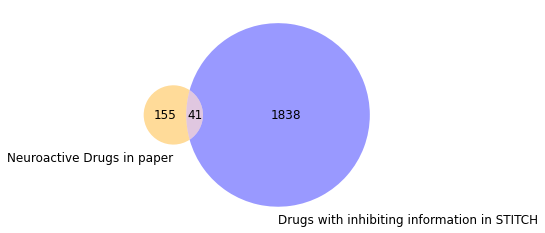

In [6]:
firstVenn=venn2([set(uniqueNeuroCIDs), set(uniqueStitchInhibitCIDs)],set_labels=('Neuroactive Drugs in paper', 'Drugs with inhibiting information in STITCH'), set_colors=('orange', 'blue'))
for text in firstVenn.subset_labels:
    text.set_fontsize(12)

### get list of drugs that have the same CID but more than one prestwick id, thus names

In [7]:
drugsSameCID=[]
for cid in uniqueNeuroCIDs:
    correspRows=PaperNeuro.loc[PaperNeuro['CIDno'] == cid]
    if len(correspRows.index) > 1: #if there are cids with more than 1 row, i.e., that have different names, get the prestwickID
        prestwickIDs=correspRows['prestwickID'].tolist()
        print('cid of the drug', cid,'/', 'prestwick cids', prestwickIDs)
        drugsSameCID.append(cid)
drugsSameCID

cid of the drug 00001207 / prestwick cids ['Prestw-109', 'Prestw-935']
cid of the drug 00002771 / prestwick cids ['Prestw-1271', 'Prestw-692']


['00001207', '00002771']

In [8]:
#number of drugs with same CID that have STITCH info.
drugsSameCIDset=set(drugsSameCID)
uniqueStitchInhibitCIDsset=set(uniqueStitchInhibitCIDs)

intersection = drugsSameCIDset.intersection(uniqueStitchInhibitCIDsset)
intersection

set()

In [9]:
STITCH_PapersInfo=pd.merge(PaperNeuro, NeuroStitchInhibit, on="CIDno")
# STITCH_PapersInfo

In [10]:
STITCH_PapersInfo=STITCH_PapersInfo.drop(columns=['CID', 'mode', 'action', 'a_is_acting'])
STITCH_PapersInfo

,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,item_id_b,score
0,Prestw-1029,Risperidone,N05AX08,human,00005073,CIDs00005073,226186.BT_0508,371
1,Prestw-1029,Risperidone,N05AX08,human,00005073,CIDs00005073,226186.BT_0072,371
2,Prestw-1029,Risperidone,N05AX08,human,00005073,CIDm00005073,226186.BT_0073,371
3,Prestw-1029,Risperidone,N05AX08,human,00005073,CIDm00005073,226186.BT_0509,371
4,Prestw-1029,Risperidone,N05AX08,human,00005073,CIDm00005073,226186.BT_0508,371
...,...,...,...,...,...,...,...,...
433,Prestw-995,Fluvoxamine maleate,N06AB08,human,00003404,CIDm00003404,226186.BT_0073,371
434,Prestw-995,Fluvoxamine maleate,N06AB08,human,00003404,CIDm00003404,226186.BT_0508,371
435,Prestw-995,Fluvoxamine maleate,N06AB08,human,00003404,CIDm00003404,226186.BT_0072,371
436,Prestw-995,Fluvoxamine maleate,N06AB08,human,00003404,CIDm00003404,226186.BT_0509,371


### Matching ids between genes and proteins

In [11]:
def matchingProteinsIDs(featureTable):
    #read strain "feature_table"
    featuresDF = pd.read_csv(featureTable, delimiter = "\t")
    OldLocusDF=featuresDF.copy()
    OldLocusDF=OldLocusDF[['locus_tag', 'attributes']]
    OldLocusDF=OldLocusDF.dropna(subset = ["attributes"])
    OldLocusDF['attributes'] = OldLocusDF['attributes'].str.split(',', n=1).str.get(-1)
    OldLocusDF['attributes'] = OldLocusDF['attributes'].str.split('=', n=1).str.get(-1)
    RefSeqIDs=featuresDF.copy()
    RefSeqIDs=RefSeqIDs[['product_accession', 'non-redundant_refseq', 'name', 'symbol', 'locus_tag']]
    RefSeqIDs = RefSeqIDs.T.drop_duplicates().T
    allIDsDF=pd.merge(OldLocusDF, RefSeqIDs, on="locus_tag")
    allIDsDF=allIDsDF.dropna(subset = ["product_accession"])
    allIDsDF=allIDsDF.dropna(subset = ["attributes"])
    allIDsDF['product_accession'] = allIDsDF['product_accession'].str.replace('.','_')
    allIDsDF=allIDsDF.rename(columns = {'locus_tag':'RefSeq_id','attributes':'STITCHid', 'product_accession':'CarveMeID', 'name':'ProteinName'})
    allIDsDF['STITCHid'] = '226186.' + allIDsDF['STITCHid'].astype(str)
    return allIDsDF

In [12]:
MatchProteinIDs=matchingProteinsIDs('GCF_000011065.1_ASM1106v1_feature_table.txt')
MatchProteinIDs

/tmp/ipykernel_683/1641403634.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  allIDsDF['product_accession'] = allIDsDF['product_accession'].str.replace('.','_')


,RefSeq_id,STITCHid,CarveMeID,ProteinName,symbol
1,BT_RS00005,226186.BT_0001,WP_011107050_1,hypothetical protein,NaN
3,BT_RS00010,226186.BT_0002,WP_009039994_1,hypothetical protein,NaN
5,BT_RS00015,226186.BT_0003,WP_009039993_1,DUF4469 domain-containing protein,NaN
7,BT_RS00020,226186.BT_0004,WP_008647129_1,hypothetical protein,NaN
9,BT_RS00030,226186.BT_0006,WP_011107052_1,hypothetical protein,NaN
...,...,...,...,...,...
9763,BT_RS24270,226186.BT_p548234,WP_005648594_1,recombinase family protein,NaN
9765,BT_RS24275,226186.BT_p548235,WP_011109635_1,Fic family protein,NaN
9767,BT_RS24280,226186.BT_p548236,WP_005648588_1,hypothetical protein,NaN
9769,BT_RS24285,226186.BT_p548237,WP_162303076_1,hypothetical protein,NaN


### read excel of matching ids between genes and proteins

In [13]:
BthetaProteinIds=MatchProteinIDs.copy()
BthetaProteinIds=BthetaProteinIds.drop(columns=["RefSeq_id"])
# BthetaProteinIds

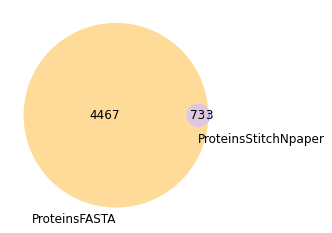

In [14]:
#Venn Diagram
ProteinsStitchNpaper=set(list(STITCH_PapersInfo.item_id_b.unique()))
ProteinsFasta=set(list(MatchProteinIDs.STITCHid.unique()))
secondVenn=venn2([ProteinsFasta, ProteinsStitchNpaper],set_labels=('ProteinsFASTA', 'ProteinsStitchNpaper'), set_colors=('orange', 'blue'))
for text in secondVenn.subset_labels:
    text.set_fontsize(12)

In [15]:
STITCH_PapersInfo=STITCH_PapersInfo.rename(columns = {'item_id_b':'STITCHid'})
# STITCH_PapersInfo

In [16]:
proteinMatching=pd.merge(BthetaProteinIds, STITCH_PapersInfo, on="STITCHid")
proteinMatching=proteinMatching.sort_values(by=['CIDno'])
proteinMatching.drop_duplicates(subset=['STITCHid', 'CarveMeID', 'prestwickID', 'CIDno'], keep="first", inplace=True)
proteinMatching

,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
213,226186.BT_1971,WP_011108073_1,catalase,NaN,Prestw-249,Bupropion hydrochloride,N06AX12,human,00000444,CIDm00000444,604
338,226186.BT_3642,WP_008762587_1,sodium-dependent transporter,NaN,Prestw-17,Levodopa,N04BA01,human,00000836,CIDm00000836,450
214,226186.BT_1971,WP_011108073_1,catalase,NaN,Prestw-458,Melatonin,N05CH01,human,00000896,CIDs00000896,604
110,226186.BT_0673,WP_008761351_1,NAD(P)H-dependent oxidoreductase,NaN,Prestw-458,Melatonin,N05CH01,human,00000896,CIDm00000896,644
292,226186.BT_3186,WP_011108698_1,dihydrolipoyl dehydrogenase,lpdA,Prestw-868,Acetaminophen,N02BE01,human,00001983,CIDm00001983,461
...,...,...,...,...,...,...,...,...,...,...,...
309,226186.BT_3386,WP_011108810_1,ABC transporter ATP-binding protein/permease,NaN,Prestw-1427,Levetiracetam,N03AX14,human,00059708,CIDs00059708,371
74,226186.BT_0509,WP_011107304_1,ABC transporter ATP-binding protein/permease,NaN,Prestw-1427,Levetiracetam,N03AX14,human,00059708,CIDm00059708,371
367,226186.BT_4486,WP_011109281_1,ion transporter,NaN,Prestw-1427,Levetiracetam,N03AX14,human,00059708,CIDm00059708,468
336,226186.BT_3642,WP_008762587_1,sodium-dependent transporter,NaN,Prestw-1328,Reboxetine mesylate,N06AX18,human,00065856,CIDm00065856,509


In [17]:
# proteinMatching.to_excel("Btheta_2018NeuroInhibit.xlsx")